# Introduction
The best Pittsburgh neighborhood has the most economic opportunities and infrastructure. We based it on these principles because the neighborhood with the most opportunity is more likely to grow, thrive, and achieve long-term success. Neighborhoods with more inactive business licenses or vacant government property suggest a stagnant population and will reflect negatively on their ranking. Other datasets, like metrics on individual business types, were considered, but did not capture the whole story of each neighborhood. The datasets we analyzed are as follows.
Assets
City-owned properties
Businesses

# City Owned Properties
For our City-owned properties metric, we first counted the total number of city-owned properties in each neighborhood. We then created a burden scale, which is simply the amount of vacant properties divided by the total number of properties in each neighborhood. We made sure to exclude neighborhoods that had fewer than 25 city-owned properties, as they would stand as an outlier and would not apply to our goal.

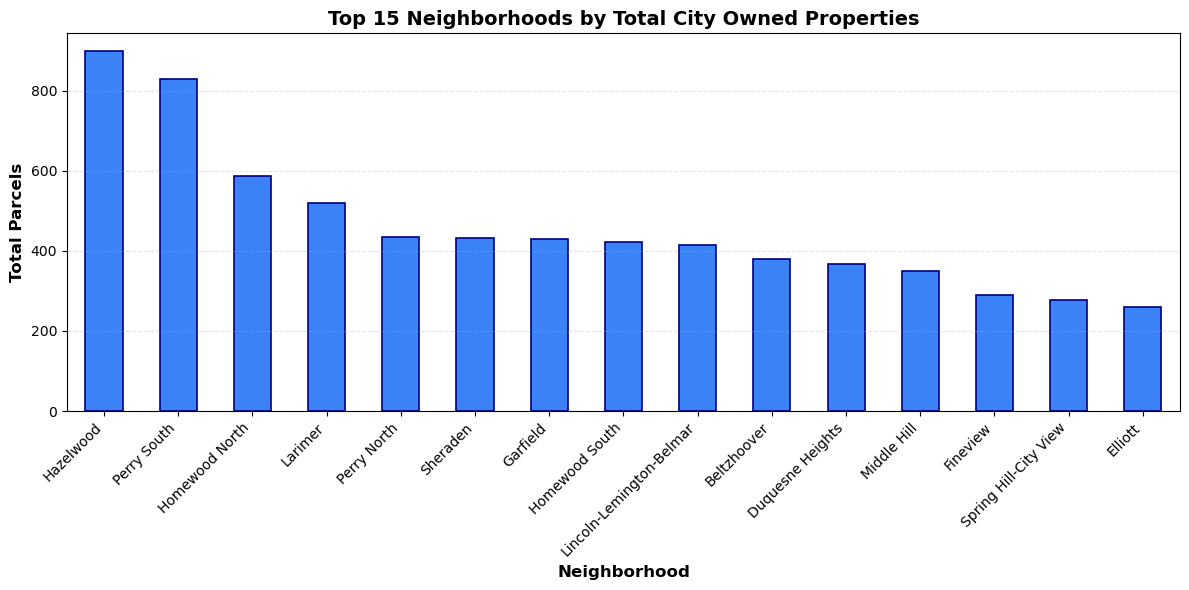

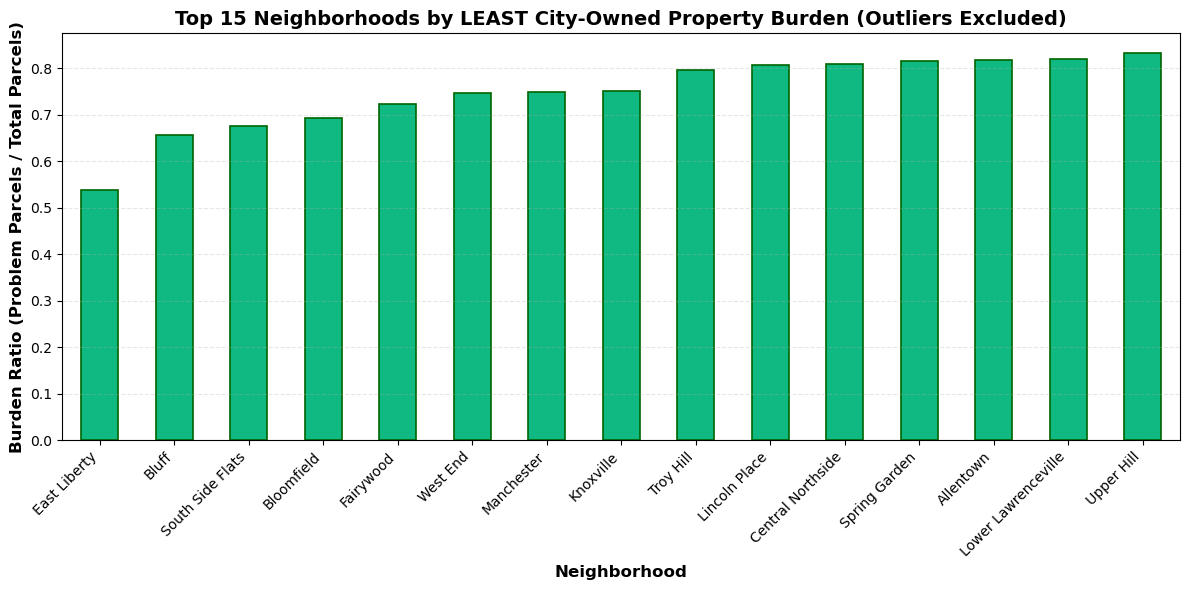


COMPREHENSIVE NEIGHBORHOOD DATA TABLE

Dataset Summary:
  • Total neighborhoods (≥25 properties): 68
  • Total city-owned parcels: 12,452
  • Total problem parcels: 11,343
  • Overall burden ratio: 91.09%

COMPLETE NEIGHBORHOOD RANKINGS
Rank   Neighborhood                        Total      Problem    Non-Prob   Burden %     Rank by Burden 
------------------------------------------------------------------------------------------------------------------------
1      Hazelwood                           898        811        87         90.3       % #29            
2      Perry South                         828        779        49         94.1       % #47            
3      Homewood North                      586        532        54         90.8       % #31            
4      Larimer                             520        481        39         92.5       % #39            
5      Perry North                         434        421        13         97.0       % #60            
6      Sher

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the city-owned properties data
city = pd.read_csv("https://data.wprdc.org/datastore/dump/e1dcee82-9179-4306-8167-5891915b62a7?bom=True", low_memory=False)

# Find neighborhood column
neighborhood_col = None
for col in city.columns:
    if 'neighborhood' in col.lower() or 'hood' in col.lower():
        neighborhood_col = col
        break

if neighborhood_col is None:
    print("Available columns:", city.columns.tolist())
    print("\nPlease specify the neighborhood column name")
else:
    # Drop rows without neighborhood
    city = city.dropna(subset=[neighborhood_col])
    
    # Find columns for problem identification
    inventory_col = None
    status_col = None
    
    for col in city.columns:
        col_lower = col.lower()
        if 'inventory' in col_lower or 'type' in col_lower:
            inventory_col = col
        if 'status' in col_lower or 'current' in col_lower:
            status_col = col
    
    # Create problem mask based on "class" column - check if it's Vacant Land or Building
    if 'class' in city.columns:
        problem_mask = city['class'].astype(str).str.contains("Vacant Land|Vacant Building", case=False, na=False)
    else:
        # Fallback to other columns if 'class' doesn't exist
        problem_mask = pd.Series([False] * len(city), index=city.index)
        
        if inventory_col:
            problem_mask |= city[inventory_col].astype(str).str.contains("Vacant|Surplus|Sideyard|Reserve", case=False, na=False)
        
        if status_col:
            problem_mask |= city[status_col].astype(str).str.contains("Vacant|Demolition|Abandoned", case=False, na=False)
    
    city["is_problem"] = problem_mask
    
    # Group by neighborhood
    city_grouped = city.groupby(neighborhood_col).agg(
        total_parcels=('class', 'count'),
        problem_parcels=('is_problem', 'sum')
    )
    
    # Calculate metrics
    city_grouped['burden_ratio'] = city_grouped['problem_parcels'] / city_grouped['total_parcels']
    city_grouped['non_problem_parcels'] = city_grouped['total_parcels'] - city_grouped['problem_parcels']
    city_grouped['burden_percentage'] = city_grouped['burden_ratio'] * 100
    
    # Filter for neighborhoods with at least 50 parcels
    city_grouped_filtered = city_grouped[city_grouped['total_parcels'] >= 25].copy()
    
    # Sort by total parcels
    city_grouped_sorted = city_grouped_filtered.sort_values('total_parcels', ascending=False)
    
    # Sort by burden ratio (ascending for least burden)
    burden_sorted = city_grouped_filtered.sort_values('burden_ratio', ascending=True)
    
    # ORIGINAL CHART 1: Top 15 Neighborhoods by Total City Owned Properties
    plt.figure(figsize=(12, 6))
    city_grouped_sorted.head(15)['total_parcels'].plot(kind='bar', color='#3b82f6', edgecolor='navy', linewidth=1.2)
    plt.title('Top 15 Neighborhoods by Total City Owned Properties', fontsize=14, fontweight='bold')
    plt.xlabel('Neighborhood', fontsize=12, fontweight='bold')
    plt.ylabel('Total Parcels', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # ORIGINAL CHART 2: Top 15 Neighborhoods by LEAST City-Owned Property Burden
    plt.figure(figsize=(12, 6))
    burden_sorted.head(15)['burden_ratio'].plot(kind='bar', color='#10b981', edgecolor='darkgreen', linewidth=1.2)
    plt.title('Top 15 Neighborhoods by LEAST City-Owned Property Burden (Outliers Excluded)', fontsize=14, fontweight='bold')
    plt.xlabel('Neighborhood', fontsize=12, fontweight='bold')
    plt.ylabel('Burden Ratio (Problem Parcels / Total Parcels)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # COMPREHENSIVE DATA TABLE
    print("\n" + "="*120)
    print("COMPREHENSIVE NEIGHBORHOOD DATA TABLE")
    print("="*120)
    print(f"\nDataset Summary:")
    print(f"  • Total neighborhoods (≥25 properties): {len(city_grouped_filtered)}")
    print(f"  • Total city-owned parcels: {city_grouped_filtered['total_parcels'].sum():,}")
    print(f"  • Total problem parcels: {int(city_grouped_filtered['problem_parcels'].sum()):,}")
    print(f"  • Overall burden ratio: {city_grouped_filtered['problem_parcels'].sum() / city_grouped_filtered['total_parcels'].sum():.2%}")
    
    print("\n" + "="*120)
    print("COMPLETE NEIGHBORHOOD RANKINGS")
    print("="*120)
    print(f"{'Rank':<6} {'Neighborhood':<35} {'Total':<10} {'Problem':<10} {'Non-Prob':<10} {'Burden %':<12} {'Rank by Burden':<15}")
    print("-"*120)
    
    # Create ranking columns
    city_grouped_sorted['rank_total'] = range(1, len(city_grouped_sorted) + 1)
    city_grouped_sorted['rank_burden'] = city_grouped_sorted['burden_ratio'].rank(ascending=True, method='min').astype(int)
    
    for idx, row in city_grouped_sorted.iterrows():
        print(f"{int(row['rank_total']):<6} {idx:<35} {int(row['total_parcels']):<10} {int(row['problem_parcels']):<10} {int(row['non_problem_parcels']):<10} {row['burden_percentage']:<11.1f}% #{int(row['rank_burden']):<14}")
    
    print("="*120)
    
    # Export to CSV
    export_df = city_grouped_sorted[['total_parcels', 'problem_parcels', 'non_problem_parcels', 'burden_ratio', 'burden_percentage']].copy()
    export_df.columns = ['Total_Parcels', 'Problem_Parcels', 'Non_Problem_Parcels', 'Burden_Ratio', 'Burden_Percentage']


 # Given this data, we can conclude that East Liberty has the smallest percentage of city burden.


# Assets
For assets we wanted to determine which assets were inside each of the Pittsburgh neighborhoods, things like parks, libraries, community centers, public facilities,etc. For this dataset I had to map each asset to a neighborhood using zip codes and the city’s census tract. How I did this was extract the 5 digit zip code then mapped it to a census tract and then mapped it to a neighborhood using the properties dataset(had zip code and neighborhood name). 

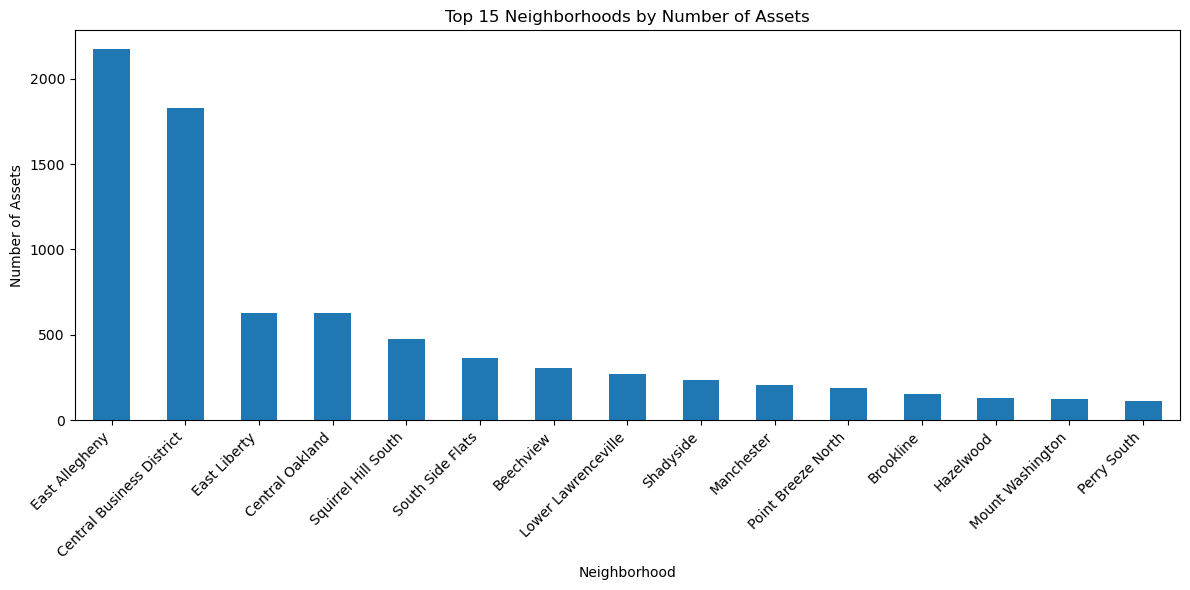

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
assets = pd.read_csv("Assets.csv", low_memory=False)
city = pd.read_csv("CityOwnedProperties.csv", low_memory=False)
zip_tract = pd.read_csv("ZIP_TRACT_032020.csv", low_memory=False)
assets_zip = assets.dropna(subset=["zip_code"]).copy()
assets_zip["zip5"] = assets_zip["zip_code"].astype(str).str.extract(r"(\d{5})")[0]
assets_zip = assets_zip.dropna(subset=["zip5"])
assets_zip["zip_int"] = assets_zip["zip5"].astype(int)
zip_tract = zip_tract.dropna(subset=["ZIP", "TRACT"]).copy()
zip_tract["ZIP_int"] = zip_tract["ZIP"].astype(int)
zip_tract["TRACT_int"] = zip_tract["TRACT"].astype("int64")
zip_primary = (
    zip_tract.sort_values("TOT_RATIO", ascending=False)
             .drop_duplicates("ZIP_int")[["ZIP_int", "TRACT_int"]]
)
city_tt = city.dropna(subset=["census_tract", "neighborhood_name"]).copy()
city_tt["census_tract_int"] = city_tt["census_tract"].astype("int64")
tract_to_hood = (
    city_tt.groupby("census_tract_int")["neighborhood_name"]
           .agg(lambda s: s.value_counts().idxmax())
           .reset_index()
)
zip_to_hood = zip_primary.merge(
    tract_to_hood,
    left_on="TRACT_int",
    right_on="census_tract_int",
    how="inner"
)
assets_with_hood = assets_zip.merge(
    zip_to_hood[["ZIP_int", "neighborhood_name"]],
    left_on="zip_int",
    right_on="ZIP_int",
    how="left"
)
assets_per_neighborhood = (
    assets_with_hood
    .dropna(subset=["neighborhood_name"])
    .groupby("neighborhood_name")["asset_id"]
    .count()
    .sort_values(ascending=False)
)
top_n = 15
plt.figure(figsize=(12, 6))
assets_per_neighborhood.head(top_n).plot(kind="bar")
plt.title(f"Top {top_n} Neighborhoods by Number of Assets")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Assets")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


The winner of this metric was east Allegheny. This makes sense because they have a high concentration of schools, libraries and parks.

# Businesses

For businesses, we wanted to look at the total number of business licenses registered in each neighborhood. The business licenses can help get a sense of the job market within each neighborhood, with neighborhoods containing more licenses having presumably more job opportunities. We determined neighborhoods based on the provided zip codes registered to each business.


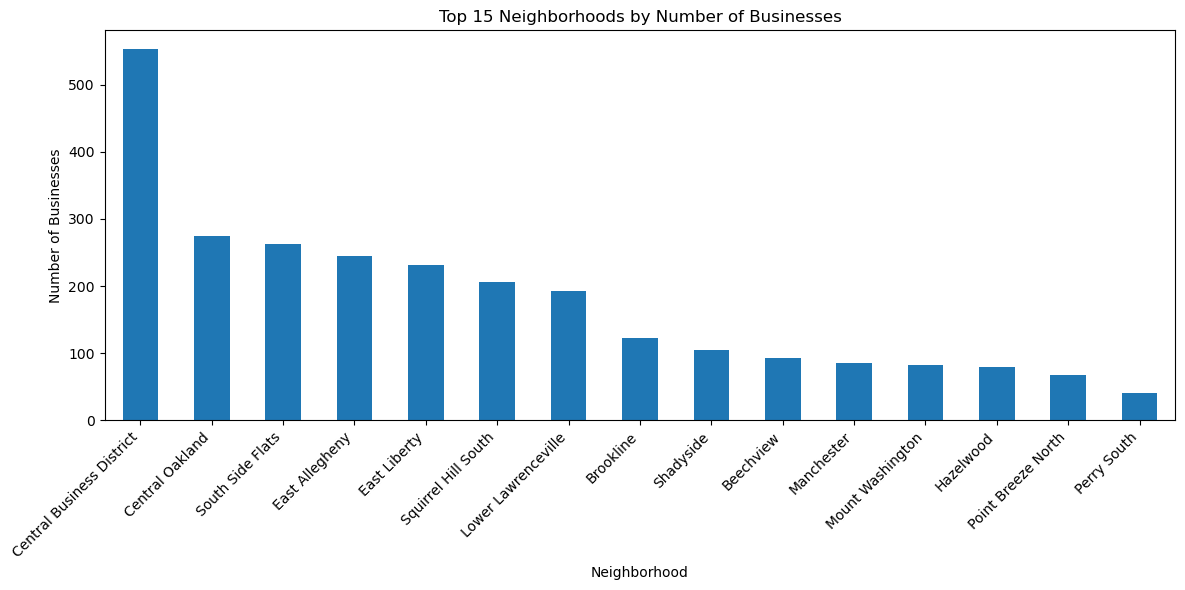

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

business = pd.read_csv("Buisness's.csv", low_memory=False)
city = pd.read_csv("CityOwnedProperties.csv", low_memory=False)
zip_tract = pd.read_csv("ZIP_TRACT_032020.csv", low_memory=False)

business["zip5"] = business["address"].astype(str).str.extract(r"(\d{5})")
business = business.dropna(subset=["zip5"])
business["zip_int"] = business["zip5"].astype(int)

zip_tract = zip_tract.dropna(subset=["ZIP", "TRACT"]).copy()
zip_tract["ZIP_int"] = zip_tract["ZIP"].astype(int)
zip_tract["TRACT_int"] = zip_tract["TRACT"].astype("int64")

zip_primary = (
    zip_tract.sort_values("TOT_RATIO", ascending=False)
             .drop_duplicates("ZIP_int")[["ZIP_int", "TRACT_int"]]
)

city_ct = city.dropna(subset=["census_tract", "neighborhood_name"]).copy()
city_ct["census_tract_int"] = city_ct["census_tract"].astype("int64")

tract_to_hood = (
    city_ct.groupby("census_tract_int")["neighborhood_name"]
           .agg(lambda s: s.value_counts().idxmax())
           .reset_index()
)

zip_to_hood = zip_primary.merge(
    tract_to_hood,
    left_on="TRACT_int",
    right_on="census_tract_int",
    how="inner"
)

business_with_hood = business.merge(
    zip_to_hood[["ZIP_int", "neighborhood_name"]],
    left_on="zip_int",
    right_on="ZIP_int",
    how="left"
)

business_counts = (
    business_with_hood
    .dropna(subset=["neighborhood_name"])
    .groupby("neighborhood_name")["business_name"]
    .nunique()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12, 6))
business_counts.head(15).plot(kind="bar")
plt.title("Top 15 Neighborhoods by Number of Businesses")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Businesses")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Based on this data, we can infer that the central business district has the highest number of job opportunities.
